https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
ДЗ - оценить возраст человека по изображению. В качестве датасета возьмите датасет только лиц. 
Предположим что сами лица вы находить и извлекать уже умеете. Можете сделать это как продолжение решения по поиску лиц из предыдущих работ.
https://www.google.com/amp/s/www.geeksforgeeks.org/age-detection-using-deep-learning-in-opencv/amp/ пример того как это может работать.  
В качестве фьючеэкстрактора берите любую современную нейронную сеть. Задачу можно решать как задачу регрессии или классификации. 
Если есть время можете попробовать 2 способа.  Попробуйте разблокировать часть слоев после обучения и дообучить модель.

Ход работы:
1. Загрузка изображений. Формирование датасета с помощью mediapipe, фильтрация данных.
2. Подготовка датасета для обучения, аугментация данных. Разбиение на возрастные категории по 5 лет.
3. Загрузка и обучение последней половины слоев модели EfficientNet_B0.


In [5]:
import os
import cv2
import mediapipe as mp
from datetime import datetime

In [3]:
import os
import cv2
import concurrent.futures
from datetime import datetime
import mediapipe as mp
import numpy as np

# Настройки
INPUT_DIR = "wiki_crop/wiki_crop"
OUTPUT_DIR = "out1"
MIN_FACE_SIZE = 20  # пикселей
TARGET_SIZE = (224, 224)  # для ResNet
MIN_AGE = 1
MAX_AGE = 100
JPEG_QUALITY = 95
NUM_THREADS = os.cpu_count() or 4

# Статистика
processed_count = 0
error_count = 0

def extract_age(filename):
    try:
        # Ожидаемый формат: 31501_1958-08-25_2012.jpg
        parts = filename.split('_')
        if len(parts) < 3:
            return None
            
        # Извлекаем дату рождения (второй элемент)
        birth_date = parts[1]  # '1958-08-25'
        birth_year = int(birth_date.split('-')[0])
        
        # Извлекаем год съемки (третий элемент, удаляем расширение)
        shoot_year = int(parts[2].split('.')[0])
        
        age = shoot_year - birth_year
        return age if (MIN_AGE <= age <= MAX_AGE) else None
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {str(e)}")
        return None

def process_image(file_path, filename, age):
    try:
        # Чтение изображения
        img = cv2.imread(file_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {file_path}")
            return None

        # Конвертация в RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Детекция лиц
        with mp.solutions.face_detection.FaceDetection(
            min_detection_confidence=0.5,
            model_selection=1
        ) as face_detection:
            
            results = face_detection.process(img_rgb)
            
            if not results.detections:
                print(f"Лица не обнаружены: {file_path}")
                return None

            # Берем первое обнаруженное лицо
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            ih, iw = img.shape[:2]
            
            x = int(bboxC.xmin * iw)
            y = int(bboxC.ymin * ih)
            w = int(bboxC.width * iw)
            h = int(bboxC.height * ih)

            if w < MIN_FACE_SIZE or h < MIN_FACE_SIZE:
                print(f"Слишком маленькое лицо: {file_path}")
                return None

            # Вырезаем лицо
            face_img = img[max(0,y):min(ih,y+h), max(0,x):min(iw,x+w)]
            h_face, w_face = face_img.shape[:2]
            
            # Ресайз с сохранением пропорций
            scale = min(TARGET_SIZE[0]/w_face, TARGET_SIZE[1]/h_face)
            new_w = int(w_face * scale)
            new_h = int(h_face * scale)
            resized = cv2.resize(face_img, (new_w, new_h))
            
            # Добавляем паддинг до нужного размера
            pad_w = (TARGET_SIZE[0] - new_w) // 2
            pad_h = (TARGET_SIZE[1] - new_h) // 2
            
            padded = cv2.copyMakeBorder(
                resized,
                top=pad_h,
                bottom=pad_h + (1 if (TARGET_SIZE[1] - new_h) % 2 else 0),
                left=pad_w,
                right=pad_w + (1 if (TARGET_SIZE[0] - new_w) % 2 else 0),
                borderType=cv2.BORDER_CONSTANT,
                value=[0,0,0]
            )
            
            return padded

    except Exception as e:
        print(f"Ошибка при обработке изображения {file_path}: {str(e)}")
        return None

def process_file(file_path):
    global processed_count, error_count
    
    try:
        filename = os.path.basename(file_path)
        age = extract_age(filename)
        if age is None:
            error_count += 1
            return None

        processed_img = process_image(file_path, filename, age)
        if processed_img is None:
            error_count += 1
            return None

        # Создаем папку для возраста, если ее нет
        age_dir = os.path.join(OUTPUT_DIR, str(age))
        os.makedirs(age_dir, exist_ok=True)
        
        output_path = os.path.join(age_dir, filename)
        cv2.imwrite(
            output_path,
            processed_img,
            [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY]
        )
        
        processed_count += 1
        if processed_count % 100 == 0:
            print(f"Обработано: {processed_count} файлов")
        return output_path

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {str(e)}")
        error_count += 1
        return None

def main():
    global processed_count, error_count
    
    # Подготовка выходной директории
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Сбор файлов
    file_paths = []
    for root, _, files in os.walk(INPUT_DIR):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(root, file))

    print(f"Найдено {len(file_paths)} файлов для обработки")

    # Многопоточная обработка
    with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        futures = {executor.submit(process_file, fp): fp for fp in file_paths}
        
        for future in concurrent.futures.as_completed(futures):
            future.result()  # Просто ждем завершения

    # Вывод статистики
    print(f"\nОбработка завершена!")
    print(f"Успешно обработано: {processed_count}")
    print(f"Ошибок обработки: {error_count}")
    print(f"Всего файлов: {len(file_paths)}")
    print(f"Процент успеха: {processed_count/len(file_paths)*100:.2f}%")

if __name__ == "__main__":
    main()

Найдено 62328 файлов для обработки
Лица не обнаружены: wiki_crop/wiki_crop\00\10416800_1907-01-08_1967.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1054800_1947-09-19_2011.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\10726900_1991-02-03_2010.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\11036200_1966-03-30_1999.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1138200_1963-02-24_2014.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\11531100_1958-05-03_2007.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1142200_1980-03-17_2010.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1157400_1938-10-01_1961.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\11581000_1982-03-16_2007.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1160300_1947-03-06_1983.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\1235700_1943-03-19_1983.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\12609600_1925-10-13_1959.jpg
Лица не обнаружены: wiki_crop/wiki_crop\00\12637400_1932-07-03_1964.jpg
Лица не обнаружены: wiki_crop/wiki_

Проверка окружения PyTorch:
PyTorch version: 2.6.0+cu126
CUDA available: True
CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1660 Ti

Загрузка данных...
Найдено изображений: 39550
После очистки осталось: 39538 изображений
Количество классов: 20


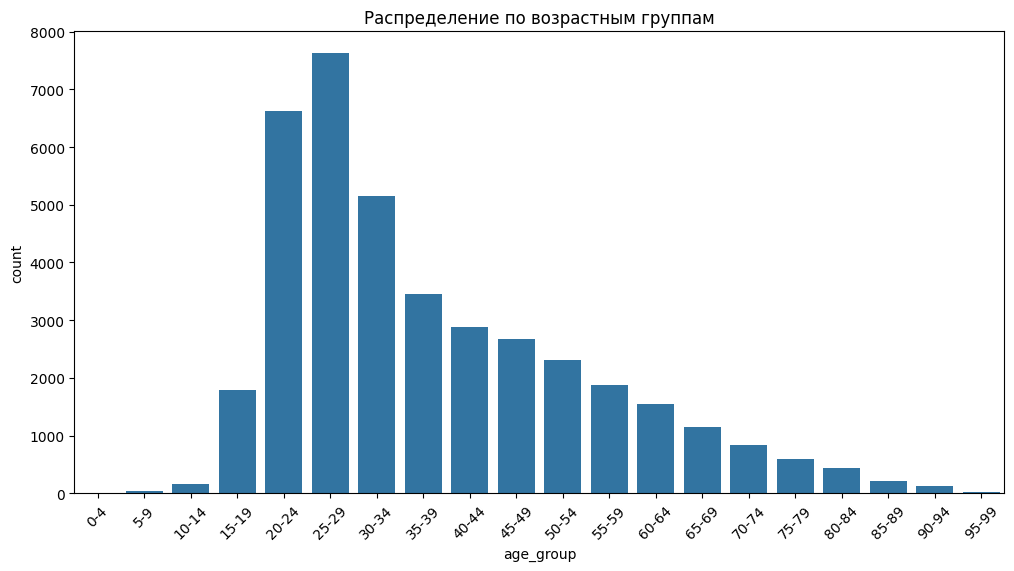


Создание датасетов...


In [33]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ==================== 1. Настройки и проверка окружения ====================
INPUT_DIR = "out1"
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

# Проверка доступности GPU
print("="*50)
print("Проверка окружения PyTorch:")
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print("Используется CPU")

print("="*50 + "\n")

# ==================== 2. Подготовка данных ====================
def create_dataframe(data_dir):
    data = []
    for age_dir in os.listdir(data_dir):
        try:
            age = int(age_dir)
            age_path = os.path.join(data_dir, age_dir)
            if not os.path.isdir(age_path):
                continue
                
            for img_file in os.listdir(age_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(age_path, img_file)
                    data.append({'path': img_path, 'age': age})
        except ValueError:
            continue
    
    return pd.DataFrame(data)

print("Загрузка данных...")
df = create_dataframe(INPUT_DIR)
print(f"Найдено изображений: {len(df)}")

# Создание возрастных групп
age_bins = list(range(0, 101, 5))
age_labels = [f"{i}-{i+4}" for i in range(0, 100, 5)]
df['age_group'] = pd.cut(df['age'], bins=age_bins, right=False, labels=age_labels)
df = df[df['age_group'].notna()]
print(f"После очистки осталось: {len(df)} изображений")

# Преобразование в числовые метки
df['age_group_label'] = df['age_group'].astype('category').cat.codes
num_classes = len(df['age_group_label'].unique())
print(f"Количество классов: {num_classes}")

# Визуализация распределения
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age_group', order=age_labels)
plt.title('Распределение по возрастным группам')
plt.xticks(rotation=45)
plt.show()

class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(TARGET_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        label = self.dataframe.loc[idx, 'age_group_label']
        
        try:
            # Проверяем, что файл существует
            if not os.path.exists(img_path):
                raise ValueError(f"Файл не существует: {img_path}")
            
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Не удалось загрузить изображение: {img_path}")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                img = self.transform(img)
                
            return img, torch.tensor(label, dtype=torch.long)  # Преобразование к int64 (torch.long)
            
        except Exception as e:
            print(f"Ошибка при обработке {img_path}: {str(e)}")
            # Возвращаем None в случае ошибки, чтобы избежать ошибки типа 'ellipsis'
            return None, None


# Фильтрация битых изображений
def filter_bad_samples(dataset):
    good_indices = []
    for i in tqdm(range(len(dataset)), desc="Проверка данных"):
        img, label = dataset[i]
        if label != -1 and not torch.isnan(img).any():
            good_indices.append(i)
    return torch.utils.data.Subset(dataset, good_indices)

# Разделение данных
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['age_group_label']
)

# Аугментации
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("\nСоздание датасетов...")
train_dataset = AgeDataset(train_df, train_transform)
test_dataset = AgeDataset(test_df, test_transform)




In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm  # ✅ Добавили tqdm для прогресса

# ==================== 1. Загрузка EfficientNet_B0 ====================
def get_model(num_classes, device):
    model = models.efficientnet_b0(pretrained=True)

    # Замораживаем первые 50% слоев
    num_frozen_layers = len(list(model.features.children())) // 2
    for i, child in enumerate(model.features.children()):
        if i < num_frozen_layers:
            for param in child.parameters():
                param.requires_grad = False

    # Заменяем последний слой
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 512),
        nn.SiLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

# ==================== 2. Гиперпараметры и загрузчики ====================
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ==================== 3. Подготовка модели и оптимизатора ====================
model = get_model(num_classes, device=DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ==================== 4. Функция обучения ====================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"\n🔥 Эпоха {epoch+1}/{epochs}")

        # === ОБУЧЕНИЕ ===
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_bar = tqdm(train_loader, desc=f"🚀 Обучение {epoch+1}/{epochs}")  # ✅ Добавлен tqdm

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=f"{loss.item():.4f}")  # ✅ Отображение текущего лосса

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # === ВАЛИДАЦИЯ ===
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        val_bar = tqdm(val_loader, desc=f"🛠 Валидация {epoch+1}/{epochs}")  # ✅ Добавлен tqdm

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                val_bar.set_postfix(loss=f"{loss.item():.4f}")  # ✅ Отображение текущего лосса

        val_loss = val_loss / total
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step()

        print(f"📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f}")
        print(f"📉 Val Loss:   {val_loss:.4f} | 🎯 Val Acc:   {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Лучшая модель сохранена!")

    return history

# ==================== 5. Запуск обучения ====================
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)


d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔥 Эпоха 1/30


🛠 Валидация 1/30: 100%|██████████| 248/248 [00:21<00:00, 11.43it/s, loss=2.3245]


📉 Train Loss: 2.2814 | 🎯 Train Acc: 0.2389
📉 Val Loss:   2.1679 | 🎯 Val Acc:   0.2575
✅ Лучшая модель сохранена!

🔥 Эпоха 2/30


🛠 Валидация 2/30: 100%|██████████| 248/248 [00:21<00:00, 11.44it/s, loss=1.6481]


📉 Train Loss: 2.1309 | 🎯 Train Acc: 0.2857
📉 Val Loss:   2.0917 | 🎯 Val Acc:   0.2934
✅ Лучшая модель сохранена!

🔥 Эпоха 3/30


🛠 Валидация 3/30: 100%|██████████| 248/248 [00:21<00:00, 11.52it/s, loss=1.6709]


📉 Train Loss: 2.0651 | 🎯 Train Acc: 0.3033
📉 Val Loss:   2.0533 | 🎯 Val Acc:   0.3045
✅ Лучшая модель сохранена!

🔥 Эпоха 4/30


🛠 Валидация 4/30: 100%|██████████| 248/248 [00:21<00:00, 11.30it/s, loss=1.6399]


📉 Train Loss: 2.0177 | 🎯 Train Acc: 0.3245
📉 Val Loss:   2.0329 | 🎯 Val Acc:   0.3092
✅ Лучшая модель сохранена!

🔥 Эпоха 5/30


🛠 Валидация 5/30: 100%|██████████| 248/248 [00:22<00:00, 11.27it/s, loss=1.7080]


📉 Train Loss: 1.9701 | 🎯 Train Acc: 0.3465
📉 Val Loss:   2.0367 | 🎯 Val Acc:   0.3137
✅ Лучшая модель сохранена!

🔥 Эпоха 6/30


🛠 Валидация 6/30: 100%|██████████| 248/248 [00:21<00:00, 11.46it/s, loss=1.5334]


📉 Train Loss: 1.9184 | 🎯 Train Acc: 0.3640
📉 Val Loss:   2.0406 | 🎯 Val Acc:   0.3170
✅ Лучшая модель сохранена!

🔥 Эпоха 7/30


🛠 Валидация 7/30: 100%|██████████| 248/248 [00:22<00:00, 10.93it/s, loss=1.5099]


📉 Train Loss: 1.8656 | 🎯 Train Acc: 0.3987
📉 Val Loss:   2.0448 | 🎯 Val Acc:   0.3154

🔥 Эпоха 8/30


🛠 Валидация 8/30: 100%|██████████| 248/248 [00:21<00:00, 11.52it/s, loss=1.7066]


📉 Train Loss: 1.8070 | 🎯 Train Acc: 0.4230
📉 Val Loss:   2.0889 | 🎯 Val Acc:   0.3042

🔥 Эпоха 9/30


🛠 Валидация 9/30: 100%|██████████| 248/248 [00:21<00:00, 11.28it/s, loss=1.9106]


📉 Train Loss: 1.7503 | 🎯 Train Acc: 0.4534
📉 Val Loss:   2.0994 | 🎯 Val Acc:   0.3102

🔥 Эпоха 10/30


🛠 Валидация 10/30: 100%|██████████| 248/248 [00:21<00:00, 11.36it/s, loss=1.8045]


📉 Train Loss: 1.6778 | 🎯 Train Acc: 0.4933
📉 Val Loss:   2.1762 | 🎯 Val Acc:   0.3015

🔥 Эпоха 11/30


🛠 Валидация 11/30: 100%|██████████| 248/248 [00:22<00:00, 11.10it/s, loss=1.7712]


📉 Train Loss: 1.6031 | 🎯 Train Acc: 0.5348
📉 Val Loss:   2.2295 | 🎯 Val Acc:   0.3102

🔥 Эпоха 12/30


🛠 Валидация 12/30: 100%|██████████| 248/248 [00:21<00:00, 11.77it/s, loss=2.9172]


📉 Train Loss: 1.5164 | 🎯 Train Acc: 0.5785
📉 Val Loss:   2.2676 | 🎯 Val Acc:   0.3112

🔥 Эпоха 13/30


🛠 Валидация 13/30: 100%|██████████| 248/248 [00:21<00:00, 11.54it/s, loss=2.3953]


📉 Train Loss: 1.4443 | 🎯 Train Acc: 0.6199
📉 Val Loss:   2.3471 | 🎯 Val Acc:   0.3025

🔥 Эпоха 14/30


🛠 Валидация 14/30: 100%|██████████| 248/248 [00:21<00:00, 11.80it/s, loss=2.0865]


📉 Train Loss: 1.3602 | 🎯 Train Acc: 0.6621
📉 Val Loss:   2.4165 | 🎯 Val Acc:   0.3036

🔥 Эпоха 15/30


🛠 Валидация 15/30: 100%|██████████| 248/248 [00:22<00:00, 11.22it/s, loss=2.0183]


📉 Train Loss: 1.2786 | 🎯 Train Acc: 0.7040
📉 Val Loss:   2.4925 | 🎯 Val Acc:   0.3010

🔥 Эпоха 16/30


🛠 Валидация 16/30: 100%|██████████| 248/248 [00:22<00:00, 11.21it/s, loss=2.4058]


📉 Train Loss: 1.2072 | 🎯 Train Acc: 0.7430
📉 Val Loss:   2.5480 | 🎯 Val Acc:   0.2946

🔥 Эпоха 17/30


🚀 Обучение 17/30:  89%|████████▉ | 878/989 [02:31<00:19,  5.78it/s, loss=1.1300]


KeyboardInterrupt: 

При обучении наибольший accuracy на валидационной выборке составил 0.3170, после чего модель начала переобучаться. Результат сложно назвать хорошим...
К сожалению, не хватило времени на большее количество экспериментов с моделями и вариантами представления входных данных.